In [1]:
import math
import re
import numpy as np
import pandas as pd

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [4]:
import os
import boto3
import botocore
import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
%pwd

'/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/collegier/notebooks'

In [6]:
%cd ..

/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/collegier


In [7]:
import sys
sys.path.append('src')
import ouraws

In [8]:
S3_BUCKET="collegier"
OUTPUT_DIR="data"
SCHOOL="austin"
SUBJECT="opinion"
START_YEAR=2011
FINAL_YEAR=2022

In [9]:
def getCovDispersion(wv):
    N = len(wv)
    cov = np.cov(wv)
    return (N, 
            np.trace(cov)/N, 
            np.linalg.norm(cov, ord=1)/N, 
            np.linalg.norm(cov, ord=2)/N, 
            np.linalg.norm(cov, ord=np.inf)/N, 
            )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [10]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]

In [11]:
len(diversity_words)

15

In [12]:
[(w) for w in diversity_words]

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [13]:
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [14]:
diversity_pattern = "|".join(diversity_lemmas)

In [15]:
diversity_pattern

'diversity|equity|inclusion|inclusive|inclusivity|equality|equal opportunity|social justice|racial justice|multi-cultural|multicultural|intercultural|intersectional|intersectionality|anti-discrimination'

In [16]:
text = "This is a multicultural organization that advocates for diversity and racial justice."
len(re.findall(diversity_pattern, text))

3

In [17]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split()
                           if w not in english_stopwords))
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    text_series = text_series.dropna()
    total_diversity_words = sum([len(re.findall(diversity_pattern, text))
                                for text in text_series])
    return text_series, total_diversity_words

In [18]:
%pwd

'/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/collegier'

In [19]:
S3OBJECT_KEY = f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-SNAPSHOT.parquet"
df = ouraws.getFromS3(S3OBJECT_KEY)

In [20]:
df.shape

(5713, 6)

In [21]:
df.columns

Index(['title', 'url', 'body', 'year', 'month', 'day'], dtype='object')

In [22]:
df["year"].unique()

array([2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012,
       2011, 2010])

In [23]:
df.loc[(df.year==2011) & (df.month==5)]

,title,url,body,year,month,day
5561,"\n\t\t\t\t\t\t\t\t\t\t\t\tThank you, Shirley B...",https://thedailytexan.com/2011/05/12/thank-you...,"Thank you, Shirley Bird\nOn May 9, I attended ...",2011,5,12
5562,\n\t\t\t\t\t\t\t\t\t\t\t\tWhats AP style for ...,https://thedailytexan.com/2011/05/06/what%c2%9...,Whats AP style for asshattery?\nI’ve lured ...,2011,5,6
5563,\n\t\t\t\t\t\t\t\t\t\t\t\tI’m being paid for t...,https://thedailytexan.com/2011/05/06/im-being-...,I’m being paid for this?\nAs a graduating seni...,2011,5,6
5564,\n\t\t\t\t\t\t\t\t\t\t\t\tI hate everyone\t\t\...,https://thedailytexan.com/2011/05/06/i-hate-ev...,I hate everyone\nAt the corner of Guadalupe an...,2011,5,6
5565,\n\t\t\t\t\t\t\t\t\t\t\t\tThey let me write my...,https://thedailytexan.com/2011/05/06/they-let-...,"They let me write my own headline\nHelen,\n\n\...",2011,5,6
5566,\n\t\t\t\t\t\t\t\t\t\t\t\tWho said it: Perry o...,https://thedailytexan.com/2011/05/05/who-said-...,Who said it: Perry or my 11-year-old sister?\n...,2011,5,5
5567,\n\t\t\t\t\t\t\t\t\t\t\t\tCheckoff laws enable...,https://thedailytexan.com/2011/05/05/checkoff-...,Checkoff laws enable twisted relationship\nI f...,2011,5,5
5568,"\n\t\t\t\t\t\t\t\t\t\t\t\tFates, interests int...",https://thedailytexan.com/2011/05/05/fates-int...,"Fates, interests intertwined\nIn the latest an...",2011,5,5
5569,\n\t\t\t\t\t\t\t\t\t\t\t\tHands off UT\t\t\t\t...,https://thedailytexan.com/2011/05/04/hands-off...,Hands off UT\nAn internal memorandum obtained ...,2011,5,4
5570,\n\t\t\t\t\t\t\t\t\t\t\t\tKeep hydrofracking c...,https://thedailytexan.com/2011/05/04/keep-hydr...,Keep hydrofracking costs in proper perspective...,2011,5,4


In [24]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]
    
    clean_df, num_diversity_words = prepText(year_df.body)
    wv = [nlp(s) for s in clean_df]
    
    docmatrix = np.array([v.vector for v in wv])
    
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    print(f"{year}, {cov[0]}, {cov[1]}, {pairwise}")
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2],
              'norm-2':   cov[3],
              'norm-inf': cov[4],
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0]
             }
    results.append(result)

2011, 385, 1.9870823270168712, 0.08513776643135253
2012, 484, 1.9685984033059352, 0.09745040083200734
2013, 513, 1.8939842069290607, 0.08733858915794113
2014, 542, 1.9335006190141895, 0.08720085167856553
2015, 632, 1.9851626933953415, 0.0821974595692523
2016, 650, 2.0035409778873943, 0.07295119107135485
2017, 686, 1.9878887053563532, 0.07219258659917116
2018, 608, 2.0660076842283472, 0.07751157508524713
2019, 354, 2.073045926194815, 0.07107210739418562
2020, 328, 2.081016950570937, 0.06765393186437524
2021, 222, 2.046958796081326, 0.05772450737244588
2022, 231, 2.0497199014257372, 0.059751318433551914


In [25]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2011,0.085138,385,1.987082,2.177459,1.822639,2.177459,59,0.153247
2012,0.097450,484,1.968598,2.063346,1.781399,2.063346,179,0.369835
2013,0.087339,513,1.893984,2.095292,1.732344,2.095292,164,0.319688
2014,0.087201,542,1.933501,2.059779,1.769460,2.059779,158,0.291513
2015,0.082197,632,1.985163,2.114991,1.826902,2.114991,308,0.487342
2016,0.072951,650,2.003541,2.114663,1.858819,2.114663,326,0.501538
2017,0.072193,686,1.987889,2.161399,1.845499,2.161399,297,0.432945
2018,0.077512,608,2.066008,2.265707,1.910615,2.265707,314,0.516447
2019,0.071072,354,2.073046,2.237005,1.926963,2.237005,157,0.443503


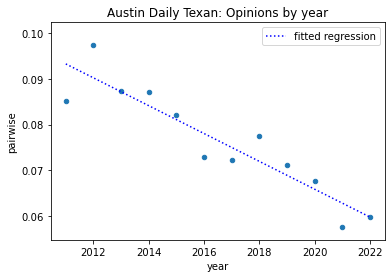

In [26]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="pairwise", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Austin Daily Texan: Opinions by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

mentions-norm slope:0.03938, int:0.23658, r:0.85607, p:0.00038, se:0.00752, x:range(0, 12)
pairwise slope:-0.00304, int:0.09325, r:-0.92374, p:0.00002, se:0.00040, x:range(0, 12)
trace slope:0.01269, int:1.93660, r:0.78191, p:0.00266, se:0.00320, x:range(0, 12)
norm-1 slope:0.01319, int:2.08391, r:0.64011, p:0.02496, se:0.00501, x:range(0, 12)
norm-2 slope:0.01753, int:1.76004, r:0.87881, p:0.00017, se:0.00301, x:range(0, 12)
norm-inf slope:0.01319, int:2.08391, r:0.64011, p:0.02496, se:0.00501, x:range(0, 12)


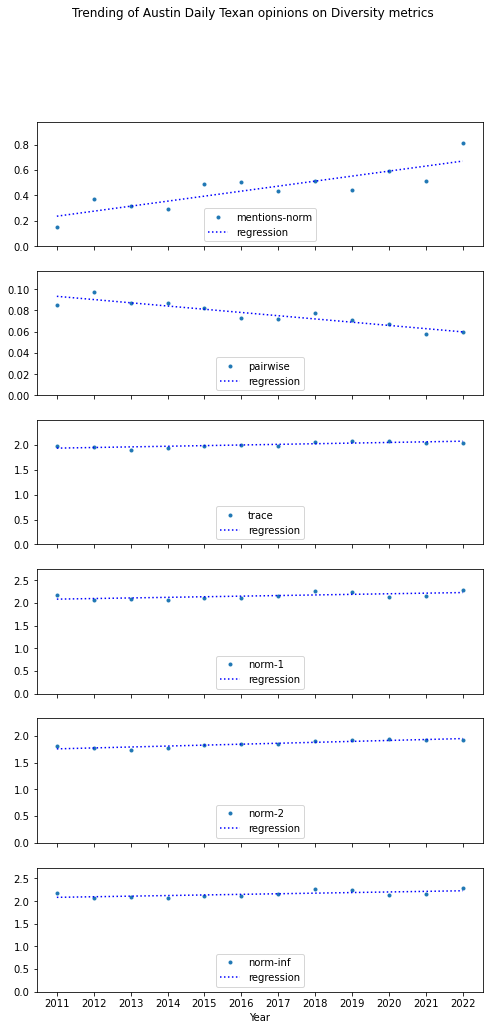

In [27]:
columns = ["mentions-norm", "pairwise", "trace", "norm-1", "norm-2", "norm-inf"]

fig, axs = plt.subplots(nrows=len(columns), ncols=1, sharex=True, figsize=(8, 16))

for ax, column in zip(axs, columns):
    x = range(len(results_df.index))
    y = results_df[column]
    
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))
    
    results_df[column].plot(ax=ax,  style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    ax.legend(loc='lower center')
    
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)
    
plt.xlabel("Year")
plt.suptitle("Trending of Austin Daily Texan opinions on Diversity metrics")
plt.show()

mentions-norm slope:0.03938, int:0.23658, r:0.85607, p:0.00038, se:0.00752, x:range(0, 12)
pairwise slope:-0.00304, int:0.09325, r:-0.92374, p:0.00002, se:0.00040, x:range(0, 12)


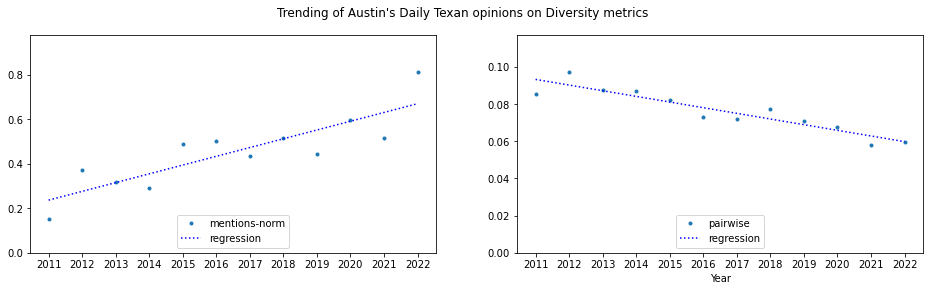

In [28]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)

    # Add a title
    # ax.set_title(f"Trending of {column} in Austin's Daily Texan")
    
plt.xlabel("Year")
plt.suptitle("Trending of Austin's Daily Texan opinions on Diversity metrics")
plt.show()

In [6]:
import requests

BIPARTISAN_API_KEY = "gAAAAABeVpQJKRM5BqPX91XW2AKfz8pJosk182maAweJcm5ORAkkBFj__d2feG4H5KIeOKFyhUVSY_uGImiaSBCwy2L6nWxx4g=="
BIPARTISAN_URL = "https://api.thebipartisanpress.com/api/endpoints/beta/robert"
df2022 = df[df['year'] == 2022]
articles_list = df2022['body'].to_list()
for article in articles_list:
    payload = {"API": BIPARTISAN_API_KEY, "Text": article.encode("utf-8")}
    response = requests.post(BIPARTISAN_URL, data=payload)
    print(response.text)
    break

NameError: name 'df' is not defined